# Clinical Efficacy of Medications for Diabetic Emergencies


Dataset link: https://www.kaggle.com/datasets/jimschacko/10-years-diabetes-dataset/data
Data dictionary: https://www.hindawi.com/journals/bmri/2014/781670/tab1/

In [1]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import warnings


warnings.filterwarnings("ignore")

# Data Preparation

In [2]:
# upload df with data 
df = pd.read_csv("diabetes_10years.csv")

In [3]:
df.head()

,id,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,...,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
0,1,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,...,No,No,No,No,No,No,No,No,No,NO
1,2,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,3,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,...,No,No,No,No,No,No,No,No,Yes,NO
3,4,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,5,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
df_cols = df.columns.to_list()
df_cols

['id',
 'encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide.metformin',
 'glipizide.metformin',
 'glimepiride.pioglitazone',
 'metformin.rosiglitazone',
 'metformin.pioglitazone',
 'change',
 'diabetesMed',
 'readmitted']

## EDA

In [5]:
# using data dict at 
# https://www.hindawi.com/journals/bmri/2014/781670/tab1/

# deletes columns that have too many missing values (over half) or are irrelevant to outcome analysis 
df = df.drop(columns=['id', 'encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
                 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses'])

In [6]:
# deletes rows that weren't prescribed diabetes meds 
mask = df['diabetesMed'] != 'No'
df = df[mask]

# deletes entire column now that every entry was prescribed diabetes meds 
df = df.drop(columns=['diabetesMed'])

In [7]:
# deletes rows that don't have race 
mask = df['race'] != '?'
df = df[mask]

In [8]:
df.head()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,examide,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,readmitted
1,Caucasian,Female,[10-20),3,59,0,18,0,0,0,...,No,No,Up,No,No,No,No,No,Ch,>30
2,AfricanAmerican,Female,[20-30),2,11,5,13,2,0,1,...,No,No,No,No,No,No,No,No,No,NO
3,Caucasian,Male,[30-40),2,44,1,16,0,0,0,...,No,No,Up,No,No,No,No,No,Ch,NO
4,Caucasian,Male,[40-50),1,51,0,8,0,0,0,...,No,No,Steady,No,No,No,No,No,Ch,NO
5,Caucasian,Male,[50-60),3,31,6,16,0,0,0,...,No,No,Steady,No,No,No,No,No,No,>30


### Heatmap
Pairwise relationship between age and readmittance frequency. 

Text(95.72222222222221, 0.5, 'age (Years)')

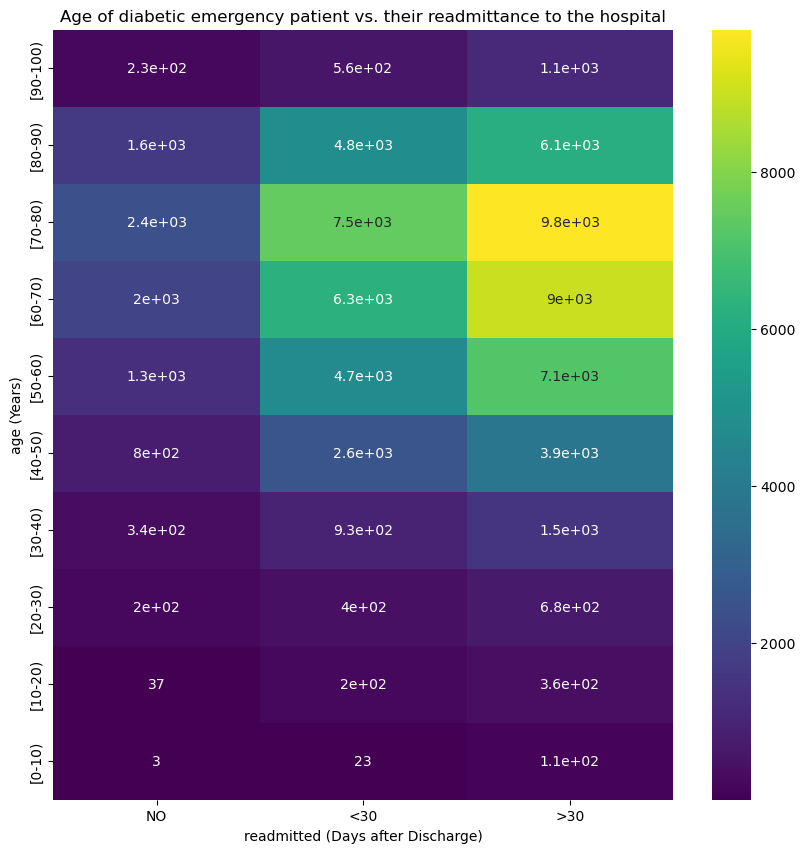

In [9]:
# creates heatmap
cross_tab = pd.crosstab(df['age'], df['readmitted'])
fig, ax = plt.subplots(figsize=(10 , 10))
sns.heatmap(cross_tab[::-1], annot=True, ax=ax, cmap='viridis', xticklabels=['NO', '<30', '>30'])
ax.set_title('Age of diabetic emergency patient vs. their readmittance to the hospital')
ax.set_xlabel('readmitted (Days after Discharge)')
ax.set_ylabel('age (Years)')

### Heatmap
Pairwise relationship between age and length of hospital stay. 

Text(95.72222222222221, 0.5, 'age (Years)')

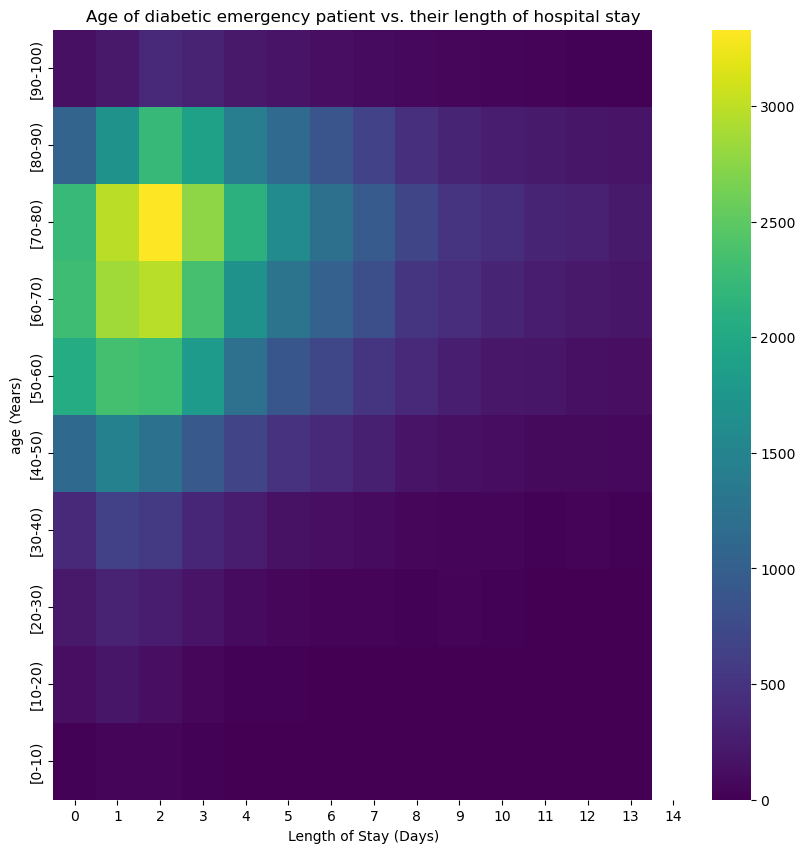

In [10]:
# creates heatmap
cross_tab = pd.crosstab(df['age'], df['time_in_hospital'])
fig, ax = plt.subplots(figsize=(10 , 10))
sns.heatmap(cross_tab[::-1], ax=ax, cmap='viridis', xticklabels=np.arange(0, 15))
ax.set_title('Age of diabetic emergency patient vs. their length of hospital stay')
ax.set_xlabel('Length of Stay (Days)')
ax.set_ylabel('age (Years)')

## Feature Engineering

In [11]:
# partition data 
X = df[['race',
 'gender',
 'age',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide.metformin',
 'glipizide.metformin',
 'glimepiride.pioglitazone',
 'metformin.rosiglitazone',
 'metformin.pioglitazone',
 'change',
 'readmitted']]   # get input features 
y = df['time_in_hospital']   # get target 

X_train, X_test, y_train, y_test = train_test_split(X,              #the input features
                                                    y,              #the label
                                                    test_size=0.3,  #set aside 30% of the data as the test set
                                                    random_state=7, #reproduce the results
                                                    stratify=y      #preserve the distribution of the labels
                                                   )

In [12]:
X_train = X_train.copy()
X_test  = X_test.copy()

In [13]:
categorical_feats = ['race',
 'gender',
 'age',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide.metformin',
 'glipizide.metformin',
 'glimepiride.pioglitazone',
 'metformin.rosiglitazone',
 'metformin.pioglitazone',
 'change',
 'readmitted']

numerical_feats = ['num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient']

In [14]:
# encode categorical features 

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='if_binary') # drop one of the encoded columns if binary values
encoder.fit(X_train[categorical_feats])   # fit

# view categories  
# print(encoder.categories_)

# transform training data 
X_train_encoded = encoder.transform(X_train[categorical_feats])
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_feats), index=X_train.index)

# zip encoded X_train and original X_train
X_train = pd.concat([X_train[numerical_feats], X_train_encoded], axis=1)

# transform test data 
X_test_encoded = encoder.transform(X_test[categorical_feats])
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_feats), index=X_test.index)

# zip encoded X_train and original X_train
X_test = pd.concat([X_test[numerical_feats], X_test_encoded], axis=1)

In [15]:
# normalize the numeric features 

scaler = StandardScaler()
scaler.fit(X_train[numerical_feats])   # fit

X_train[numerical_feats] = scaler.transform(X_train[numerical_feats])   # scale training data 

X_test[numerical_feats] = scaler.transform(X_test[numerical_feats])   # scale test data 

In [16]:
# view prepared data 
X_train.head()

,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,...,glyburide.metformin_Steady,glyburide.metformin_Up,glipizide.metformin_Steady,glimepiride.pioglitazone_Steady,metformin.rosiglitazone_No,metformin.pioglitazone_Steady,change_No,readmitted_<30,readmitted_>30,readmitted_NO
77859,-0.172748,1.545030,-0.346324,-0.295167,-0.214826,0.260472,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
22906,-0.273548,-0.198183,-0.103728,-0.295167,-0.214826,-0.513700,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
45399,-0.676746,-0.779254,-0.346324,-0.295167,-0.214826,-0.513700,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9982,-0.878346,-0.198183,3.292617,-0.295167,-0.214826,-0.513700,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
29446,0.028851,-0.198183,0.017570,-0.295167,-0.214826,-0.513700,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


# K-NN Neighbors Classifier

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(53544, 100)
(22948, 100)
(53544,)
(22948,)


In [18]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [19]:
# view metrics 

# accuracy
print('The accuracy of the model is: {}'.format(knn.score(X_test, y_test)))

The accuracy of the model is: 0.179187728778107


## Hyperparameter Tuning
### Experimentation with different numbers of neighbors with cross-validation

In [20]:
params = {'n_neighbors': np.arange(3, 25, 2)}

knn_cv_hyper = KNeighborsClassifier()

# initialize GridSearch with Cross Validation
knn_grid = GridSearchCV(knn_cv_hyper, params, cv=5, scoring='accuracy', verbose=1)
knn_grid.fit(X_train, y_train)   # fit

print(knn_grid.best_params_)
print(knn_grid.best_score_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
{'n_neighbors': 23}
0.1961378286927864


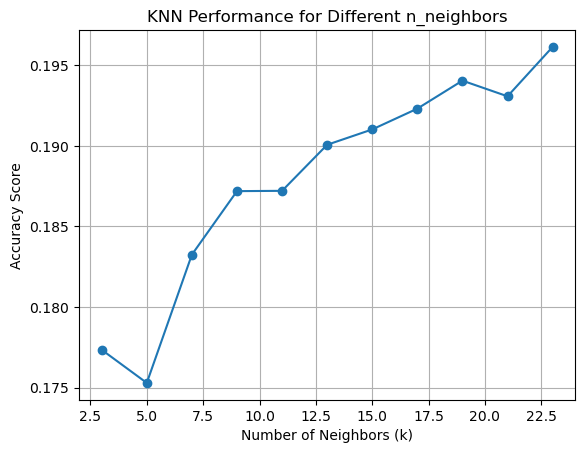

In [21]:
# plot results
results = pd.DataFrame(knn_grid.cv_results_)

plt.figure()
plt.plot(results['param_n_neighbors'], results['mean_test_score'], marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy Score')
plt.title('KNN Performance for Different n_neighbors')
plt.grid(True)
plt.show()

In [22]:
# get classification report for recommended value of k 
knn_23 = KNeighborsClassifier(n_neighbors=23) # init model
knn_23.fit(X_train, y_train)
y_pred = knn_23.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.25      0.33      0.29      2889
           2       0.21      0.35      0.26      3813
           3       0.20      0.31      0.24      4031
           4       0.15      0.16      0.15      3196
           5       0.14      0.08      0.11      2313
           6       0.11      0.06      0.07      1732
           7       0.10      0.04      0.06      1357
           8       0.12      0.03      0.05      1031
           9       0.09      0.02      0.03       711
          10       0.05      0.01      0.01       544
          11       0.11      0.01      0.02       436
          12       0.10      0.01      0.01       351
          13       0.30      0.01      0.02       295
          14       0.08      0.01      0.01       249

    accuracy                           0.19     22948
   macro avg       0.15      0.10      0.10     22948
weighted avg       0.17      0.19      0.17     22948



# Random Forest Classifier

In [23]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=7)

# Fit the model on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Classifier Accuracy:", accuracy)

Random Forest Classifier Accuracy: 0.1914763813839986


## Hyperparameter Tuning
### Experimentation with different numbers of estimators & different max depths with cross-validation

In [24]:
# setup parameter grid 
params = {'n_estimators': np.arange(50, 250, 50),
          'max_depth': [None, 10, 25]}

# init rf classifier
rf_cv_hyper = RandomForestClassifier()

# initialize GridSearch with Cross Validation
rf_grid = GridSearchCV(rf_cv_hyper, params, cv=5, scoring='accuracy', verbose=1)
rf_grid.fit(X_train, y_train)   # fit

print(rf_grid.best_params_)
print(rf_grid.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'max_depth': 10, 'n_estimators': 200}
0.21554237508011115


In [25]:
# get classification report for recommended parameters

rf_tuned = RandomForestClassifier(n_estimators=200, max_depth=10) # init model
rf_tuned.fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.38      0.21      0.27      2889
           2       0.27      0.44      0.33      3813
           3       0.20      0.55      0.29      4031
           4       0.13      0.11      0.12      3196
           5       0.13      0.03      0.05      2313
           6       0.06      0.01      0.01      1732
           7       0.08      0.01      0.02      1357
           8       0.13      0.01      0.02      1031
           9       0.00      0.00      0.00       711
          10       0.00      0.00      0.00       544
          11       0.00      0.00      0.00       436
          12       0.00      0.00      0.00       351
          13       0.00      0.00      0.00       295
          14       0.00      0.00      0.00       249

    accuracy                           0.22     22948
   macro avg       0.10      0.10      0.08     22948
weighted avg       0.17      0.22      0.16     22948



# Support Vector Machine

In [26]:
# instantiate SVM model
svm = SVC()
svm.fit(X_train, y_train) # fit the training data
y_pred = svm.predict(X_test) # make predictions on the test set

accuracy_svm = accuracy_score(y_test, y_pred) # evaluate accuracy
print("Support Vector Machine Classifier Accuracy:", accuracy_svm)

Support Vector Machine Classifier Accuracy: 0.21718668293533205


## Hyperparameter Tuning
### Experimentation with different values of c and gamma with cross-validation

In [ ]:
# using GridSearchCV to tune hyperparameters C and gamma 
params = {'C': np.arange(1, 10),
         'gamma': np.arange(1, 5)}

svm_hyper = SVC()

# initialize GridSearch with CV
svm_grid = GridSearchCV(estimator = svm_hyper, param_grid = params, cv=5, return_train_score = True)
svm_grid.fit(X_train, y_train)

print('The best model/parameters are: {}'.format(svm_grid.best_params_)) #print the best parameters
print('The best score that was obtained was: {}'.format(svm_grid.best_score_)) #print the best score

In [ ]:
# display the cv results for the train and test set

cv_results = pd.DataFrame(svm_grid.cv_results_)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)
cv_results[['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']].head()

# Results and Evaluations
Pre-processing Observations:
Heatmaps shown to the right show that there are indeed pairwise relationships within the patients’ characteristics. 

1. K-Nearest Neighbors (KNN):
Accuracy: 0.1961
KNN achieves low accuracy, with the accuracy score increasing somewhat with different values of k tried, but never landing on one being better than the rest or above 0.2. 

2. Random Forest Classifier:
Accuracy: 0.2155
Random Forest achieves a higher accuracy score than KNN, but not by much.

3. Support Vector Machine (SVM):
Accuracy: 0.2172
The SVM model achieved a higher baseline accuracy score without tuning, but GridSearchCV validation was unable to run to completion with the time allotted. 

Among the Models:
Out of all the models, the SVM model performed the best. However, there are qualifiers to that statement. 

K-Nearest Neighbors (KNN) showcased low accuracy, which indicates that it wasn’t able to perform pattern recognition well. When tuning for the best number of neighbors to use,  the model never rose above 0.2 accuracy and also didn’t indicate that there was a standout value. 
Random Forest fared slightly better, with hyperparameter tuning elucidating a max depth of 10 and 200 estimators as the most accurate. Before the tuning, the model was over 2% less accurate.  The multiple decision trees added robust complexity that boosted the performance over the nearest-neighbors method. 
Support Vector Machine (SVM), while exhibiting better accuracy before tuning than the classifiers before, was unable to complete hyperparameter tuning with cross validation. The parameters tested, C and gamma, would have changed the regularization strength and kernel coefficient. It can be assumed that the tuning would’ve elucidated a score higher than the baseline, which is already better than those of the other models. 

As such, every model that was tested was weaker than would be preferred for usage or conclusions. **SVM stands out as the most potent model in this context, but its focus on higher-dimensionality greatly increased runtime.**